In [2]:
# Keras, dataset, and VGG19 imports
import keras
from keras.datasets import cifar100, cifar10
from keras.applications import VGG19
from google.colab import drive
import time
import imageio

In [3]:
# Loading VGG19 with imagenet weights
from keras.layers import Input

vgg19_model = VGG19(include_top = True, weights='imagenet')
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

# define new empty model
model = Sequential()

# add all layers except output from VGG19 to new model
for layer in vgg19_model.layers[:-1]:
  model.add(layer)

# freeze all weights
for layer in model.layers:
  layer.trainable = False

# add dropout layer and new output layer
model.add(Dropout(0.5))
model.add(Dense(200, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [5]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

fatal: destination path 'IMagenet' already exists and is not an empty directory.
test  train  val  wnids.txt  words.txt


In [6]:
drive.mount( '/content/drive', force_remount=True )
path = 'IMagenet/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict

def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [imageio.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), mode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(imageio.imread( path + 'val/images/{}'.format(img_name) ,mode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)



tiny_img_net = get_id_dictionary()
# (X_train, Y_train), (X_test,Y_test) = cifar10.get_data()
X_train, Y_train, x_test, y_test = get_data(tiny_img_net)

def shuffle_data(train_data, train_labels ):
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)

    return train_data[train_idx], train_labels[train_idx]



x_train, y_train = shuffle_data(X_train, Y_train)

Mounted at /content/drive
starting loading data


<ipython-input-6-26eacac8aded>:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_data += [imageio.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), mode='RGB') for i in range(500)]
<ipython-input-6-26eacac8aded>:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test_data.append(imageio.imread( path + 'val/images/{}'.format(img_name) ,mode='RGB'))


finished loading data, in 71.19694232940674 seconds


In [17]:
# load dataset
(x_train, y_train) , (x_val, y_val) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [1]:
import numpy as np
import cv2

In [ ]:
import matplotlib.pyplot as plt

NUM_CLASSES = 200

# Onehot encode labels

y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val = keras.utils.to_categorical(y_val, NUM_CLASSES)

In [9]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [13]:
# returns batch_size random samples from either training set or validation set
# resizes each image to (224, 244, 3), the native input size for VGG19
def getBatch(batch_size, train_or_val='train'):
  x_batch = []
  y_batch = []
  if train_or_val == 'train':
    idx = np.random.randint(0, len(x_train), (batch_size))

    for i in idx:
      img = cv2.resize(x_train[i], (224, 224), interpolation=cv2.INTER_CUBIC)
      x_batch.append(img)
      y_batch.append(y_train[i])
  elif train_or_val == 'val':
    idx = np.random.randint(0, len(x_test), (batch_size))

    for i in idx:
      img = cv2.resize(x_test[i], (224, 224), interpolation=cv2.INTER_CUBIC)
      x_batch.append(img)
      y_batch.append(y_test[i])
  else:
    print("error, please specify train or val")

  x_batch = np.array(x_batch)
  y_batch = np.array(y_batch)
  return x_batch, y_batch


In [14]:
EPOCHS = 10
BATCH_SIZE = 128
VAL_SIZE = 500
STEPS = 50


for e in range(EPOCHS):
  train_loss = 0
  train_acc = 0

  for s in range(STEPS):
    x_batch, y_batch = getBatch(BATCH_SIZE, "train")
    out = model.train_on_batch(x_batch, y_batch)
    train_loss += out[0]
    train_acc += out[1]

  print(f"Epoch: {e}\nTraining Loss = {train_loss / STEPS}\tTraining Acc = {train_acc / STEPS}")

  x_v, y_v = getBatch(VAL_SIZE, "val")
  eval = model.evaluate(x_v, y_v)
  print(f"Validation loss: {eval[0]}\tValidation Acc: {eval[1]}\n")




Epoch: 0
Training Loss = 3.8418569231033324	Training Acc = 0.2925
16/16 [==============================] - 15s 512ms/step - loss: 2.9801 - categorical_accuracy: 0.3840
Validation loss: 2.980125665664673	Validation Acc: 0.3840000033378601

Epoch: 1
Training Loss = 3.591319136619568	Training Acc = 0.34328125
16/16 [==============================] - 3s 166ms/step - loss: 2.6940 - categorical_accuracy: 0.4440
Validation loss: 2.694023370742798	Validation Acc: 0.4440000057220459

Epoch: 2
Training Loss = 3.4285754585266113	Training Acc = 0.37359375
16/16 [==============================] - 3s 164ms/step - loss: 2.9954 - categorical_accuracy: 0.4120
Validation loss: 2.995417833328247	Validation Acc: 0.41200000047683716

Epoch: 3
Training Loss = 3.36851761341095	Training Acc = 0.38515625
16/16 [==============================] - 3s 165ms/step - loss: 2.9816 - categorical_accuracy: 0.4080
Validation loss: 2.981630325317383	Validation Acc: 0.40799999237060547

Epoch: 4
Training Loss = 3.279797105

In [15]:
x_v, y_v = getBatch(VAL_SIZE, "val")
eval1 = model.evaluate(x_v, y_v)
print(f"Validation loss: {eval1[0]}\tValidation Acc: {eval1[1]}\n")

16/16 [==============================] - 3s 159ms/step - loss: 2.8875 - categorical_accuracy: 0.4440
Validation loss: 2.887481927871704	Validation Acc: 0.4440000057220459



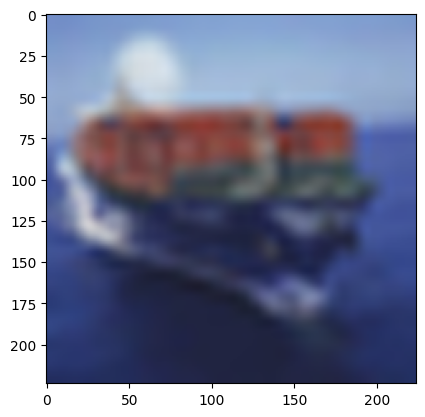

1/1 [==============================] - 0s 162ms/step
pred: bicycle
acct: bicycle


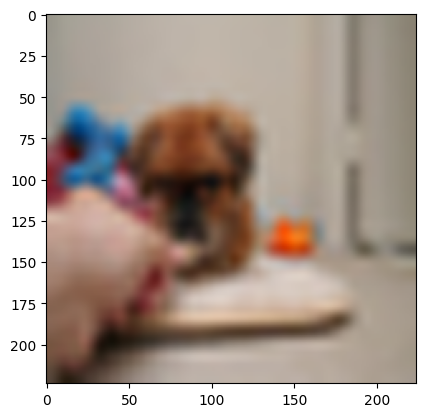

1/1 [==============================] - 0s 18ms/step
pred: bed
acct: bed


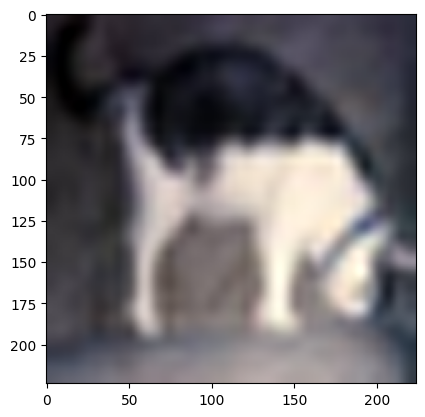

1/1 [==============================] - 0s 18ms/step
pred: bed
acct: bear


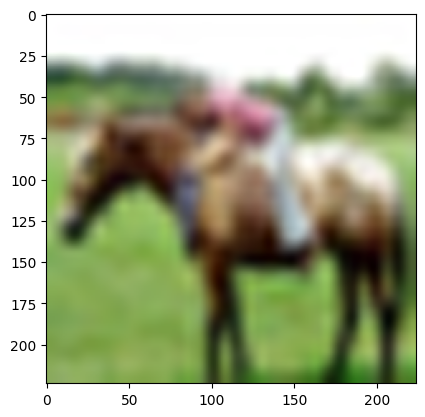

1/1 [==============================] - 0s 18ms/step
pred: beetle
acct: beetle


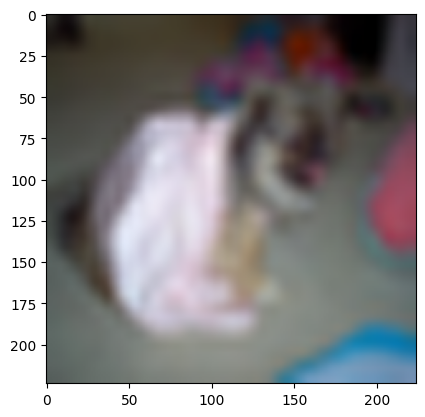

1/1 [==============================] - 0s 18ms/step
pred: bed
acct: bed


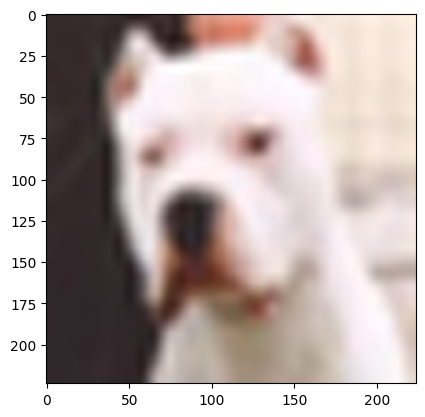

1/1 [==============================] - 0s 18ms/step
pred: bed
acct: bed


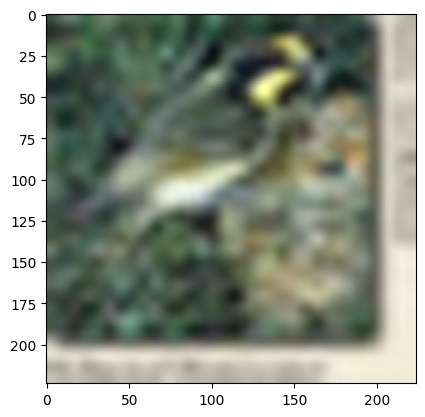

1/1 [==============================] - 0s 18ms/step
pred: baby
acct: baby


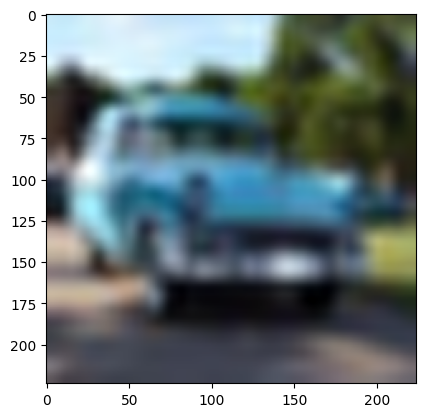

1/1 [==============================] - 0s 18ms/step
pred: bottle
acct: aquarium_fish


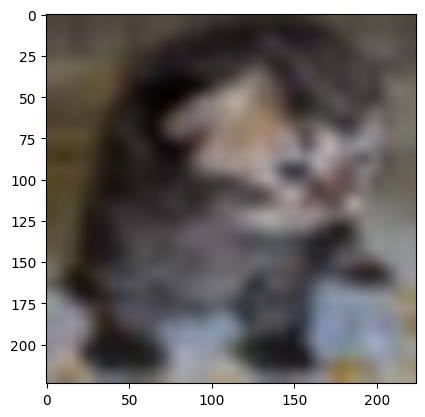

1/1 [==============================] - 0s 28ms/step
pred: bear
acct: bear


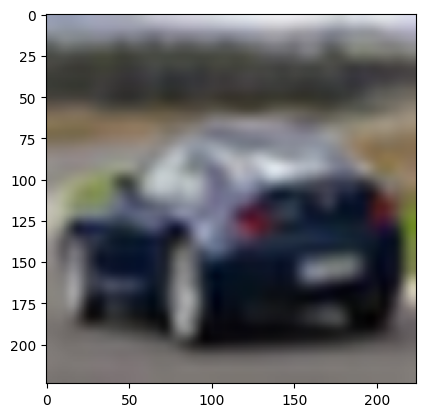

1/1 [==============================] - 0s 49ms/step
pred: aquarium_fish
acct: aquarium_fish


In [23]:
# Sample outputs from validation set
CATEGORIES = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"
]

import matplotlib.pyplot as plt

x_v, y_v = getBatch(10, "val")

for i in range(10):

  import numpy as np
  plt.imshow(x_v[i])
  plt.show()
  print("pred: " +  CATEGORIES[np.argmax(model.predict(x_v[i:i+1]))])
  print("acct: " + CATEGORIES[np.argmax(y_v[i])])





In [13]:
import pandas as pd
hist_df = pd.DataFrame(out.history)
hist_csv_file = '/vgg_cifar10.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

model.save('/vgg_cifar10.keras')

AttributeError: 'list' object has no attribute 'history'